# Bar Learning problem

The implementation of the bar learning problem is located in the
`examples/bar_learning` folder. The bar learning problem describes the
process of learning receptive fields on an artificial input pattern.
Images consisting of independent bars are used. Those images are
generated as following: an 8\*8 image can filled randomly by eight
horizontal or vertical bars, with a probability of 1/8 for each.

These input images are fed into a neural population, whose neurons
should learn to extract the independent components of the input
distribution, namely single horizontal or vertical bars.

If you have `pyqtgraph` installed, you can simply try the network by
typing:

~~~
python BarLearning.py
~~~


## Model overview

The model consists of two populations `Input` and `Feature`. The size of
`Input` should be chosen to fit the input image size (here 8\*8). The
number of neurons in the `Feature` population should be higher than the
total number of independent bars (16, we choose here 32 neurons). The
`Feature` population gets excitory connections from `Input` through an
all-to-all connection pattern. The same pattern is used for the
inhibitory connections within `Feature`.

## Defining the neurons and populations

In [1]:
from ANNarchy import *
clear()

#setup(paradigm="cuda")

ANNarchy 4.6 (4.6.0b) on linux (posix). 


**Input population:**

The input pattern will be clamped into this population by the main
loop for every trial, so we need just an empty neuron at this
point:

In [2]:
InputNeuron = Neuron(parameters="r = 0.0")

The trick here is to declare `r` as a parameter, not a variable: its
value will not be computed by the simulator, but only set by external
input. The `Input` population can then be created:

In [3]:
Input = Population(geometry=(8, 8), neuron=InputNeuron)

**Feature population:**

The neuron type composing this population sums up all the excitory
inputs gain from `Input` and the lateral inhibition within `Feature`.

$$\tau \frac {dr_{j}^{\text{Feature}}}{dt} + r_{j}^{Feature} = \sum_{i} w_{ij} \cdot r_{i}^{\text{Input}}  - \sum_{k, k \ne j} w_{kj} * r_{k}^{Feature}$$

could be implemented as the following:


In [4]:
LeakyNeuron = Neuron(
    parameters=""" 
        tau = 10.0 : population
    """,
    equations="""
        tau * dr/dt + r = sum(exc) - sum(inh) : min=0.0
    """
)

The firing rate is restricted to positive values with the `min=0.0`
flag. The population is created in the following way:

In [5]:
Feature = Population(geometry=(8, 4), neuron=LeakyNeuron)

We give it a (8, 4) geometry for visualization only, it does not
influence computations at all.

## Defining the synapse and projections

Both feedforward (`Input` $\rightarrow$ `Feature`) and lateral
(`Feature` $\rightarrow$ `Feature`) projections are learned using the
Oja learning rule (a regularized Hebbian learning rule ensuring the sum
of all weights coming to a neuron is constant). Only some parameters will
differ between the projections.

$$\tau \frac{dw_{ij}}{dt} = r_{i} * r_{j} - \alpha * r_{j}^{2} * w_{ij}$$

where $\alpha$ is a parameter defining the strength of the
regularization, $r_i$ is the pre-synaptic firing rate and $r_j$ the
post-synaptic one. The implementation of this synapse type is
straightforward:

In [6]:
Oja = Synapse(
    parameters=""" 
        tau = 2000.0 : postsynaptic
        alpha = 8.0 : postsynaptic
        min_w = 0.0 : postsynaptic
    """,
    equations="""
        tau * dw/dt = pre.r * post.r - alpha * post.r^2 * w : min=min_w
    """
)  

For this network we need to create two projections, one excitory between
the populations `Input` and `Feature` and one inhibitory within the
`Feature` population itself:

In [7]:
ff = Projection(
    pre=Input, 
    post=Feature, 
    target='exc', 
    synapse = Oja    
)
ff.connect_all_to_all(weights = Uniform(-0.5, 0.5))
                     
lat = Projection(
    pre=Feature, 
    post=Feature, 
    target='inh', 
    synapse = Oja
)
lat.connect_all_to_all(weights = Uniform(0.0, 1.0))

The two projections are all-to-all and use the `Oja` synapse type. They
only differ by the parameter `alpha` (lower in `lat`) and
the fact that the weights of `ff` are allowed to be negative
(so we set the minimum value to -10.0):

In [8]:
ff.min_w = -10.0
lat.alpha = 0.3

## Setting inputs

Once the network is defined, one has to specify how inputs are fed into
the `Input` population. A simple solution is to define a method that
sets the firing rate of `Input` according to the specified probabilities
every time it is called, and runs the simulation for 50 ms:

In [9]:
def trial():
    # Reset the firing rate for all neurons
    Input.r = 0.0
    # Clamp horizontal bars randomly
    for h in range(Input.geometry[0]):
        if np.random.random() < 1.0/ float(Input.geometry[0]):
            Input[h, :].r = 1.0
    # Clamp vertical bars randomly
    for w in range(Input.geometry[1]):
        if np.random.random() < 1.0/ float(Input.geometry[1]):
            Input[:, w].r = 1.0
    # Simulate for 50ms
    simulate(50.)
    # Return firing rates and receptive fields for visualization
    return Input.r, Feature.r, ff.receptive_fields()

One can use here a single value or a Numpy array (e.g.
`np.zeros(Input.geometry))`) to reset activity in Input, it does not matter.

For all possible horizontal bars, a decision is then made whether the
bar should appear or not, in which case the firing rate of the
correspondng neurons is set to 1.0:

``` {.python}
    for h in range(Input.geometry[0]):
        if np.random.random() < 1.0/ float(Input.geometry[0]):
            Input[h, :].r = 1.0
```

`Input[h, :]` is a PopulationView, i.e. a group of neurons defined by
the sub-indices (here the row of index `h`). Their attributes, such as
`r`, can be accessed as if it were a regular population. The same is
done for vertical bars.

## Running the simulation

Once the method for setting inputs is defined, the simulation can be
started. A basic approach would be to define a `for` loop where the
`trial()` method is called repetitively:

In [10]:
compile()

for t in range(1000):
    input_r, feature_r, weights = trial()

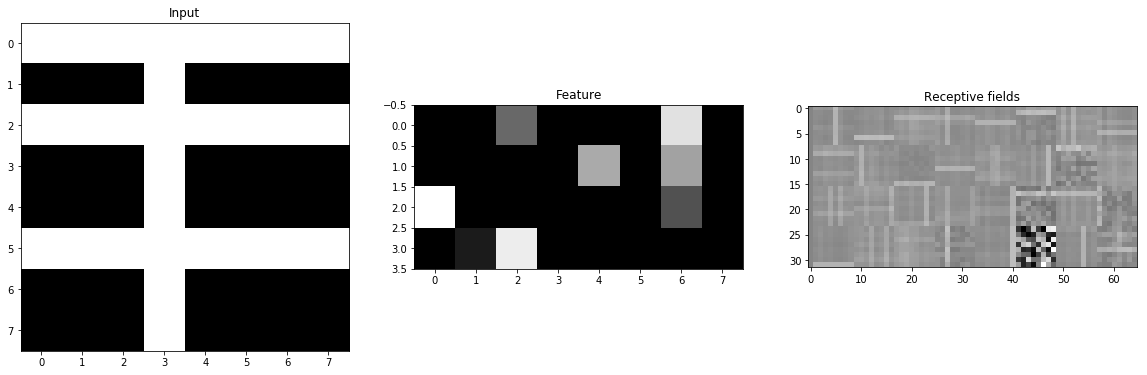

In [11]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20.0, 15.0)

plt.subplot(131)
plt.imshow(input_r.T, interpolation='nearest', cmap=plt.cm.gray)
plt.title('Input')
plt.subplot(132)
plt.imshow(feature_r.T, interpolation='nearest', cmap=plt.cm.gray)
plt.title('Feature')
plt.subplot(133)
plt.imshow(weights.T, interpolation='nearest', cmap=plt.cm.gray)
plt.title('Receptive fields')
plt.show()

In the file `BarLearning.py`, a visualization class using `pyqtgraph` is
imported from `Viz.py`, but the user is free to use whatever method he prefers to
visualize the result of learning.

```python
from Viz import Viewer
view = Viewer(func=trial)
view.run()
```